In [1]:

from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'



C:\Users\lobof\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])


In [5]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [6]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


In [7]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [8]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


In [9]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [10]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [11]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=20,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 54s 7ms/step - loss: 0.9233 - val_loss: 0.9702
Epoch 2/20
8000/8000 [==============================] - 54s 7ms/step - loss: 0.7336 - val_loss: 0.7959
Epoch 3/20
8000/8000 [==============================] - 55s 7ms/step - loss: 0.6230 - val_loss: 0.7193
Epoch 4/20
8000/8000 [==============================] - 55s 7ms/step - loss: 0.5658 - val_loss: 0.6595
Epoch 5/20
8000/8000 [==============================] - 51s 6ms/step - loss: 0.5267 - val_loss: 0.6245
Epoch 6/20
8000/8000 [==============================] - 54s 7ms/step - loss: 0.4949 - val_loss: 0.5967
Epoch 7/20
8000/8000 [==============================] - 56s 7ms/step - loss: 0.4686 - val_loss: 0.5769
Epoch 8/20
8000/8000 [==============================] - 56s 7ms/step - loss: 0.4459 - val_loss: 0.5646
Epoch 9/20
8000/8000 [==============================] - 52s 7ms/step - loss: 0.4260 - val_loss: 0.5442
Epoch 10/20
8000/8000 [==

In [12]:
# Save model
model.save('s2s.h5')

C:\Users\lobof\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [34]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=20,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 84s 10ms/step - loss: 0.1537 - acc: 0.2728 - val_loss: 0.5436 - val_acc: 0.2309
Epoch 2/20
8000/8000 [==============================] - 81s 10ms/step - loss: 0.1472 - acc: 0.2752 - val_loss: 0.5493 - val_acc: 0.2316
Epoch 3/20
8000/8000 [==============================] - 84s 10ms/step - loss: 0.1436 - acc: 0.2763 - val_loss: 0.5587 - val_acc: 0.2304
Epoch 4/20
8000/8000 [==============================] - 83s 10ms/step - loss: 0.1401 - acc: 0.2773 - val_loss: 0.5645 - val_acc: 0.2299
Epoch 5/20
8000/8000 [==============================] - 84s 11ms/step - loss: 0.1371 - acc: 0.2780 - val_loss: 0.5667 - val_acc: 0.2309
Epoch 6/20
8000/8000 [==============================] - 83s 10ms/step - loss: 0.1338 - acc: 0.2791 - val_loss: 0.5717 - val_acc: 0.2316
Epoch 7/20
8000/8000 [==============================] - 81s 10ms/step - loss: 0.1307 - acc: 0.2799 - val_loss: 0.5799 - val_acc: 0.2310


In [37]:
# Save model
model.save('s3s.h5')

C:\Users\lobof\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


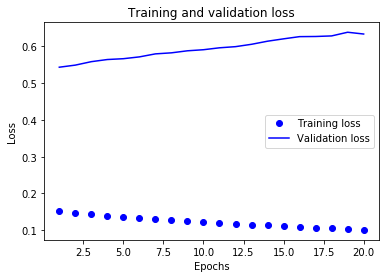

In [35]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

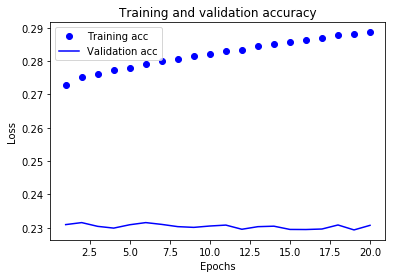

In [36]:

plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c  = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)



In [16]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [17]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [18]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Parde toi !

-
Input sentence: Run!
Decoded sentence: Aidez-vous !

-
Input sentence: Run!
Decoded sentence: Aidez-vous !

-
Input sentence: Wow!
Decoded sentence: Laisse la mainon !

-
Input sentence: Fire!
Decoded sentence: Attendez-vous à l'i porti !

-
Input sentence: Help!
Decoded sentence: Sais-toi !

-
Input sentence: Jump.
Decoded sentence: Attends un chez voir !

-
Input sentence: Stop!
Decoded sentence: Arrête de trinquir !

-
Input sentence: Stop!
Decoded sentence: Arrête de trinquir !

-
Input sentence: Stop!
Decoded sentence: Arrête de trinquir !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Va charcher ton sentie !

-
Input sentence: Go on.
Decoded sentence: Va charcher ton sentie !

-
Input sentence: Go on.
Decoded sentence: Va charcher ton sentie !

-
Input sentence: I see.
Decoded sentence: J'ai été incoré.

-
Input sentence: